In [1]:
from importlib import reload

import octopus.dataset as ds
import octopus.visualization.plotting as vis
from octopus.core import metrics
from octopus.preprocessing import compute_grad_image

In [2]:
scans, inits, gts = ds.load_dataset()

idx_list = list(scans.keys())

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cv2

def multi_prediction_zoom_plot(scan, predictions, gt_elm=None, figsize=(12, 10), zoom_region=None):
    """
    Display multiple ELM predictions overlaid on the OCT scan with a zoom-in box.

    Parameters:
    - scan: 2D numpy array representing the OCT scan
    - predictions: dict where keys are model names and values are numpy arrays of shape (N, 2)
    - gt_elm: numpy array of shape (N, 2) for ground-truth ELM coordinates (optional)
    - figsize: tuple, size of the figure (width, height) in inches
    - zoom_region: tuple (x1, x2, y1, y2) specifying the region to zoom in
    
    Returns:
    - fig: matplotlib figure object
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Normalize scan to 0-255 range
    scan_normalized = ((scan - scan.min()) / (scan.max() - scan.min()) * 255).astype(np.uint8)
    scan_rgb = cv2.cvtColor(scan_normalized, cv2.COLOR_GRAY2RGB)

    # Display the scan
    ax.imshow(scan_rgb)

    # Color cycle for different predictions
    colors = plt.cm.rainbow(np.linspace(0, 1, len(predictions) + 1))  # +1 for ground truth
    legend_elements = []

    # Plot ground truth ELM if provided
    if gt_elm is not None:
        ax.scatter(gt_elm[:, 1], gt_elm[:, 0], color=colors[0], s=1, alpha=0.7, label='Ground Truth')
        legend_elements.append(Line2D([0], [0], color=colors[0], marker='o', linestyle='', markersize=5, label='Ground Truth'))

    # Plot predictions
    for (model_name, elm_coords), color in zip(predictions.items(), colors[1:]):
        ax.scatter(elm_coords[:, 1], elm_coords[:, 0], color=color, s=1, alpha=0.7, label=model_name)
        legend_elements.append(Line2D([0], [0], color=color, marker='o', linestyle='', markersize=5, label=model_name))

    # Add zoom-in box
    if zoom_region:
        x1, x2, y1, y2 = zoom_region
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', linestyle='--')
        ax.add_patch(rect)

        # Create zoomed inset
        axins = ax.inset_axes([0.05, 0.5, 0.47, 0.47],
                              xlim=(x1, x2), ylim=(y2, y1), xticklabels=[], yticklabels=[])
        axins.imshow(scan_rgb)
        axins.set_xticks([])
        axins.set_yticks([])

        # Plot zoomed predictions
        if gt_elm is not None:
            mask = (gt_elm[:, 1] >= x1) & (gt_elm[:, 1] < x2) & (gt_elm[:, 0] >= y1) & (gt_elm[:, 0] < y2)
            axins.scatter(gt_elm[mask, 1], gt_elm[mask, 0], color=colors[0], s=3, alpha=0.7)

        for (model_name, elm_coords), color in zip(predictions.items(), colors[1:]):
            mask = (elm_coords[:, 1] >= x1) & (elm_coords[:, 1] < x2) & (elm_coords[:, 0] >= y1) & (elm_coords[:, 0] < y2)
            axins.scatter(elm_coords[mask, 1], elm_coords[mask, 0], color=color, s=3, alpha=0.7)

        # Connect the zoomed region to the inset axes
        ax.indicate_inset_zoom(axins, edgecolor="white")

    # Add legend with adjusted font size
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

    # Remove ticks for a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    return fig

In [3]:
grads = dict()
c = 0
for i in idx_list:
    c += 1
    grads[i] = compute_grad_image(scans[i])
    print(f'Completed scan {c}/{len(idx_list)}')

Completed scan 1/524
Completed scan 2/524
Completed scan 3/524
Completed scan 4/524
Completed scan 5/524
Completed scan 6/524
Completed scan 7/524
Completed scan 8/524
Completed scan 9/524
Completed scan 10/524
Completed scan 11/524
Completed scan 12/524
Completed scan 13/524
Completed scan 14/524
Completed scan 15/524
Completed scan 16/524
Completed scan 17/524
Completed scan 18/524
Completed scan 19/524
Completed scan 20/524
Completed scan 21/524
Completed scan 22/524
Completed scan 23/524
Completed scan 24/524
Completed scan 25/524
Completed scan 26/524
Completed scan 27/524
Completed scan 28/524
Completed scan 29/524
Completed scan 30/524
Completed scan 31/524
Completed scan 32/524
Completed scan 33/524
Completed scan 34/524
Completed scan 35/524
Completed scan 36/524
Completed scan 37/524
Completed scan 38/524
Completed scan 39/524
Completed scan 40/524
Completed scan 41/524
Completed scan 42/524
Completed scan 43/524
Completed scan 44/524
Completed scan 45/524
Completed scan 46/5

In [22]:
i = '673-35'
test_scan = scans[i]
test_init = inits[i]
test_gt = gts[i]
test_grad = grads[i]

In [23]:
reload(vis)
reload(metrics)

<module 'octopus.core.metrics' from '/Users/uzaykaradag/Developer/octopus/octopus/core/metrics.py'>

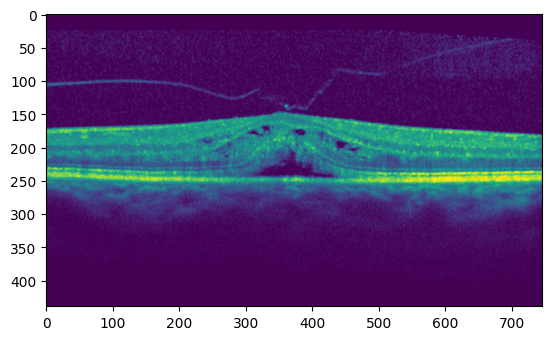

In [24]:
plt.imshow(test_scan)

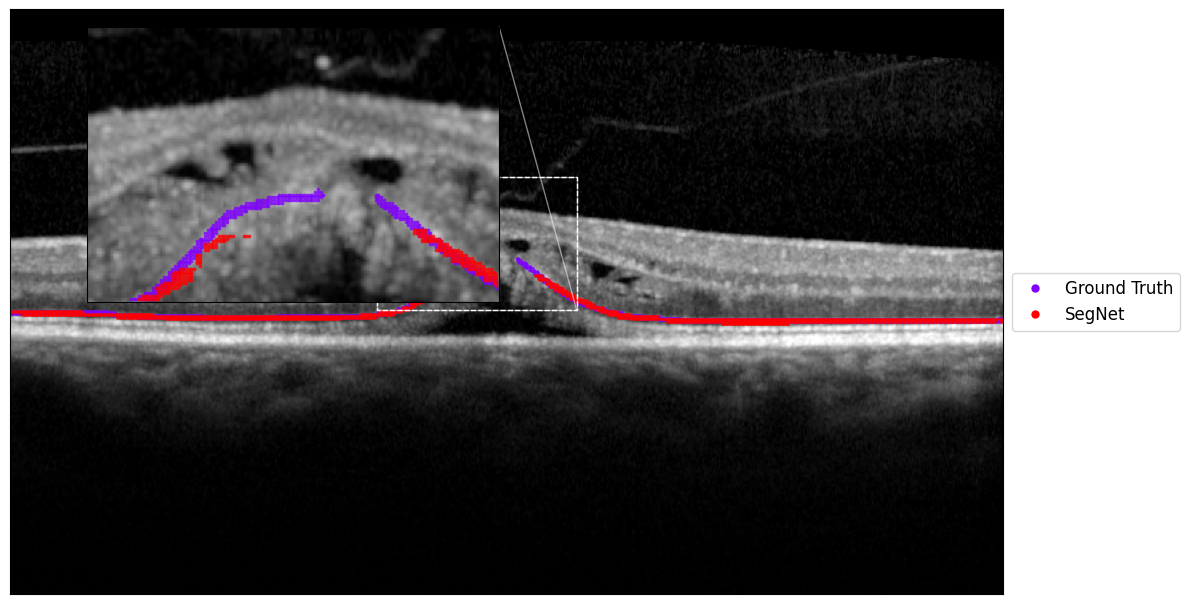

In [26]:
figs = {}
figs['SegNet'] = multi_prediction_zoom_plot(test_scan, {'SegNet': test_init}, gt_elm=test_gt, zoom_region=(275, 425, 125, 225))

## Comparison of different kernels with different parameter settings

In [27]:
rational_quad1 = {
    'kernel': 'RationalQuadratic',
    'sigma_f': 1.0,
    'length_scale': 2.5,
    'alpha': 2.0
}

exp_sine_sq1 = {
    'kernel': 'ExpSineSquared',
    'sigma_f': 1.0,
    'length_scale': 2.5,
    'period': 50.0
}

matern1 = {
    'kernel': 'Matern',
    'sigma_f': 1.0,
    'length_scale': 2.5,
    'nu': 2.5
}

In [28]:
from octopus.core import predict

rq = predict.trace_elm(test_grad, test_init, num_runs=100)

In [29]:
ess = predict.trace_elm(test_grad, test_init, kernel_options=exp_sine_sq1, num_runs=100)


In [30]:
m = predict.trace_elm(test_grad, test_init, kernel_options=matern1, num_runs=100)

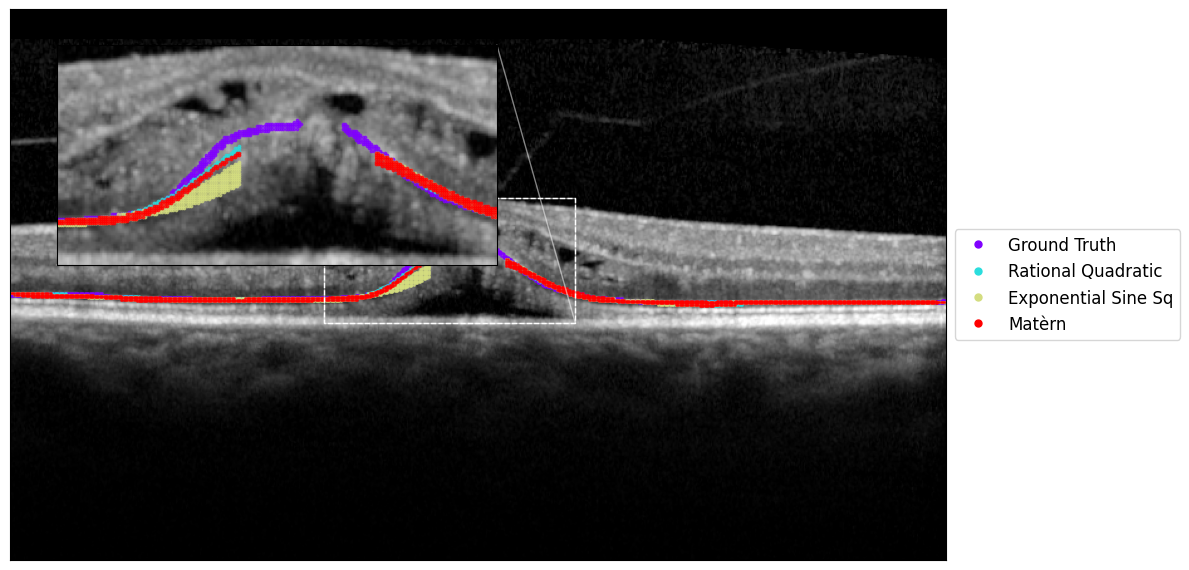

In [53]:
predictions = {
    'Rational Quadratic': rq,
    'Exponential Sine Sq': ess,
    'Matèrn': m
}

figs['Kernel_Comp_MH'] = multi_prediction_zoom_plot(test_scan, predictions, gt_elm=test_gt, zoom_region=(250, 450, 150, 250))

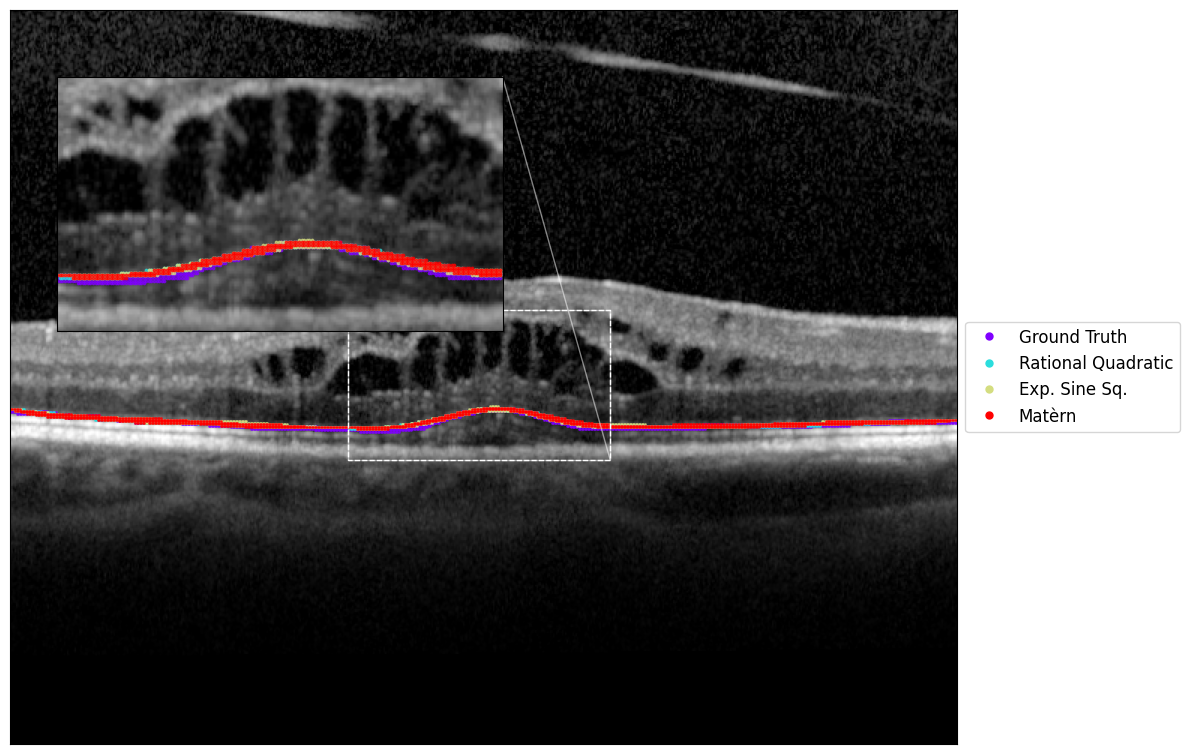

In [54]:
figs['Kernel_Comp_No_MH']

In [32]:
sn_metrics = metrics.calculate_all_metrics(test_init, test_gt, test_scan.shape)
sn_metrics

{'Dice': 0.779896013864818,
 'IoU': 0.6392045454545454,
 'Sensitivity': 0.7715387912558938,
 'FPR': 0.0014854179929327319,
 'RMSE': 0.05569871554377077,
 'Hausdorff Distance': 9.0}

In [33]:
rq_metrics = metrics.calculate_all_metrics(rq, test_gt, test_scan.shape)
rq_metrics

{'Dice': 0.7921146953405018,
 'IoU': 0.655786350148368,
 'Sensitivity': 0.7578225460780111,
 'FPR': 0.0011163700443780158,
 'RMSE': 0.05323194248070718,
 'Hausdorff Distance': 9.055385138137417}

In [34]:
ess_metrics = metrics.calculate_all_metrics(ess, test_gt, test_scan.shape)
ess_metrics

{'Dice': 0.7154435925520263,
 'IoU': 0.5569577080491133,
 'Sensitivity': 0.6999571367338191,
 'FPR': 0.0018421643432022905,
 'RMSE': 0.06298003558403076,
 'Hausdorff Distance': 11.874342087037917}

In [35]:
m_metrics = metrics.calculate_all_metrics(m, test_gt, test_scan.shape)
m_metrics

{'Dice': 0.7799244947812569,
 'IoU': 0.6392428103385511,
 'Sensitivity': 0.7526789541363051,
 'FPR': 0.0012732154225137701,
 'RMSE': 0.055009177750787855,
 'Hausdorff Distance': 10.246950765959598}

## MH

In [55]:
idx_mh = '068-23'
mh_scan = scans[idx_mh]
mh_grad = grads[idx_mh]
mh_init = inits[idx_mh]
mh_gt = gts[idx_mh]

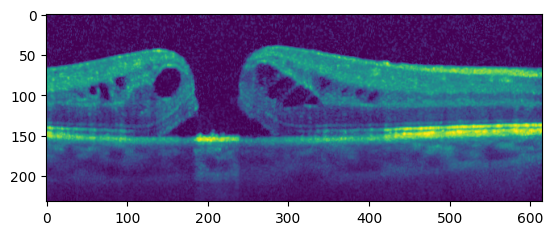

In [56]:
plt.imshow(mh_scan)

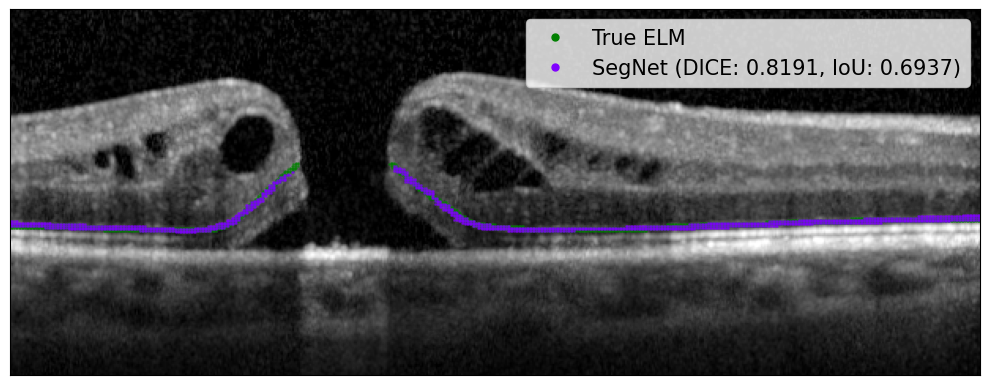

In [57]:
figs = {}
figs['SegNet_MH'] = vis.display_scan(mh_scan, {'SegNet': mh_init}, gt_elm=mh_gt)

In [59]:
rq_try1 = predict.trace_elm(mh_grad, mh_init, num_runs=100, kernel_options=rational_quad1)

In [60]:
ess_try1 = predict.trace_elm(mh_grad, mh_init, num_runs=100, kernel_options=exp_sine_sq1)

In [61]:
matern_try1 = predict.trace_elm(mh_grad, mh_init, kernel_options=matern1, num_runs=100)

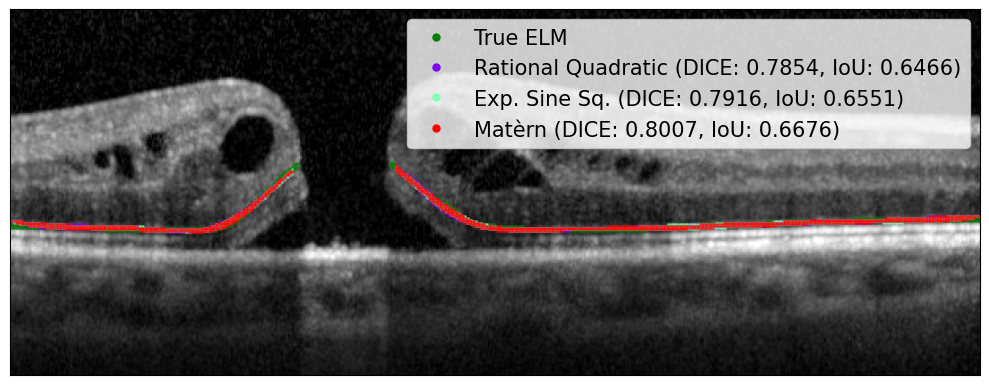

In [66]:
predictions_mh = {
    'Rational Quadratic': rq_try1,
    'Exp. Sine Sq.': ess_try1,
    'Matèrn': matern_try1
}

figs['Kernel_Comp_MH'] = vis.display_scan(mh_scan, predictions_mh, gt_elm=mh_gt, zoom_region=(50, 350, 25, 225))

In [65]:
figs['Kernel_Comp_MH'].savefig('figures/kernel_comp_mh_high_res.pdf', dpi=1200)

In [69]:
print('MH present \n ---------')
sn_metrics_mh = metrics.calculate_all_metrics(mh_init, mh_gt, mh_scan.shape)
print("SegNet \n -------")
print(sn_metrics_mh)
rq_metrics_mh = metrics.calculate_all_metrics(rq_try1, mh_gt, mh_scan.shape)
print("Rational quad. \n -------")
print(rq_metrics_mh)
ess_metrics_mh = metrics.calculate_all_metrics(ess_try1, mh_gt, mh_scan.shape)
print("ExpSineSq \n -------")
print(ess_metrics_mh)
m_metrics_mh = metrics.calculate_all_metrics(matern_try1, mh_gt, mh_scan.shape)
print("Matern \n -------")
print(m_metrics_mh)

SegNet 
 -------
{'Dice': 0.8191460429698123, 'IoU': 0.6936895439889452, 'Sensitivity': 0.8311258278145696, 'FPR': 0.0025484851066246415, 'RMSE': 0.06826990088182605, 'Hausdorff Distance': 9.1104335791443}
Rational quad. 
 -------
{'Dice': 0.785385500575374, 'IoU': 0.6466129796305069, 'Sensitivity': 0.7533112582781457, 'FPR': 0.0021225544481358436, 'RMSE': 0.07230825208311947, 'Hausdorff Distance': 9.0}
ExpSineSq 
 -------
{'Dice': 0.7916298261125847, 'IoU': 0.6551219512195122, 'Sensitivity': 0.7411699779249448, 'FPR': 0.001689524945338899, 'RMSE': 0.07039278641331083, 'Hausdorff Distance': 8.54400374531753}
Matern 
 -------
{'Dice': 0.8006872852233677, 'IoU': 0.667621776504298, 'Sensitivity': 0.7715231788079471, 'FPR': 0.0020018740948973507, 'RMSE': 0.06984302957695782, 'Hausdorff Distance': 9.433981132056603}


In [71]:
print('NO MH \n ------')
print("SegNet \n -------")
print(sn_metrics)
print("Rational quad. \n -------")
print(rq_metrics)
print("ExpSineSq \n -------")
print(ess_metrics)
print("Matern \n -------")
print(m_metrics)
print('\n\n')
print('MH present \n ---------')
sn_metrics_mh = metrics.calculate_all_metrics(mh_init, mh_gt, mh_scan.shape)
print("SegNet \n -------")
print(sn_metrics_mh)
rq_metrics_mh = metrics.calculate_all_metrics(rq_try1, mh_gt, mh_scan.shape)
print("Rational quad. \n -------")
print(rq_metrics_mh)
ess_metrics_mh = metrics.calculate_all_metrics(ess_try1, mh_gt, mh_scan.shape)
print("ExpSineSq \n -------")
print(ess_metrics_mh)
m_metrics_mh = metrics.calculate_all_metrics(matern_try1, mh_gt, mh_scan.shape)
print("Matern \n -------")
print(m_metrics_mh)

NO MH 
 ------
SegNet 
 -------
{'Dice': 0.779896013864818, 'IoU': 0.6392045454545454, 'Sensitivity': 0.7715387912558938, 'FPR': 0.0014854179929327319, 'RMSE': 0.05569871554377077, 'Hausdorff Distance': 9.0}
Rational quad. 
 -------
{'Dice': 0.7921146953405018, 'IoU': 0.655786350148368, 'Sensitivity': 0.7578225460780111, 'FPR': 0.0011163700443780158, 'RMSE': 0.05323194248070718, 'Hausdorff Distance': 9.055385138137417}
ExpSineSq 
 -------
{'Dice': 0.7154435925520263, 'IoU': 0.5569577080491133, 'Sensitivity': 0.6999571367338191, 'FPR': 0.0018421643432022905, 'RMSE': 0.06298003558403076, 'Hausdorff Distance': 11.874342087037917}
Matern 
 -------
{'Dice': 0.7799244947812569, 'IoU': 0.6392428103385511, 'Sensitivity': 0.7526789541363051, 'FPR': 0.0012732154225137701, 'RMSE': 0.055009177750787855, 'Hausdorff Distance': 10.246950765959598}



MH present 
 ---------
SegNet 
 -------
{'Dice': 0.8191460429698123, 'IoU': 0.6936895439889452, 'Sensitivity': 0.8311258278145696, 'FPR': 0.002548485106